In [17]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"
import torch
import numpy as np
import random
import pandas as pd
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import torch.nn as nn
#import pretrainedmodels
import math
import sys
import pickle
#from arch import RingGeMNet, GeMNet, L2Norm, GeM

#from arch import GeM, L2Norm
%config InlineBackend.figure_format ='retina'

SEED = 42
np.random.seed(SEED), random.seed(SEED), torch.random.manual_seed(SEED), torch.cuda.manual_seed_all(SEED)

(None, None, <torch._C.Generator at 0x7a8ac0588070>, None)

In [18]:
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [19]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class SiameseDataset(Dataset):
    def __init__(self, root_dir=None, txt_path=None, data=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []
        self.labels_mapping = {}
        self.labels_to_images = {}

        if root_dir and txt_path:
            # Traverse root directory and collect image paths
            for root, _, files in os.walk(root_dir):
                for file in files:
                    if file.lower().endswith(".jpg"):
                        relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                        corrected_path = "/".join(relative_path.split("/")[1:])
                        self.image_paths[corrected_path] = os.path.join(root, file)

            # Read the metadata from txt file
            with open(txt_path, "r") as f:
                lines = f.readlines()

            for line in lines[2:]:
                parts = line.strip().split()
                image_name, item_id, evaluation_status = parts[0], parts[1], parts[2]

                if evaluation_status == "train" and image_name in self.image_paths:
                    if item_id not in self.labels_mapping:
                        self.labels_mapping[item_id] = len(self.labels_mapping)
                    label_index = self.labels_mapping[item_id]
                    img_path = self.image_paths[image_name]
                    self.data.append((label_index, img_path))

                    # Build mapping of label to image paths
                    if label_index not in self.labels_to_images:
                        self.labels_to_images[label_index] = []
                    self.labels_to_images[label_index].append(img_path)

        if data:
            # If data is directly provided
            self.data = data
            for label, img_path in self.data:
                if label not in self.labels_to_images:
                    self.labels_to_images[label] = []
                self.labels_to_images[label].append(img_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, img_path = self.data[idx]

        # Load the first image
        image1 = Image.open(img_path).convert("RGB")
        if self.transform:
            image1 = self.transform(image1)

        # Determine whether to create a positive or negative pair
        is_positive = np.random.choice([True, False])

        if is_positive:
            # Positive pair: Same label, different image
            img_list = self.labels_to_images[label]
            filtered_list = [p for p in img_list if p != img_path]
            if not filtered_list:  
                img_path2 = img_path  # Dùng lại img_path nếu không còn ảnh nào khác
            else:
                img_path2 = np.random.choice(filtered_list)

        else:
            # Negative pair: Different label, random image
            negative_labels = [lbl for lbl in self.labels_to_images.keys() if lbl != label]
            negative_label = np.random.choice(negative_labels)
            img_list = self.labels_to_images[negative_label]
            img_path2 = np.random.choice(img_list)

        # Load the second image
        image2 = Image.open(img_path2).convert("RGB")
        if self.transform:
            image2 = self.transform(image2)

        target = 1 if is_positive else 0  # 1 for positive pairs, 0 for negative pairs

        return (image1, image2), target


In [20]:
# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

root_dir = "/kaggle/input/deepfashion1"
txt_path = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"

# Instantiate the dataset
siamese_dataset = SiameseDataset(root_dir=root_dir, txt_path=txt_path, transform=transform)




--- Retrieving Pair 0 ---
Pair 0:
 - Target: 1 (Positive)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


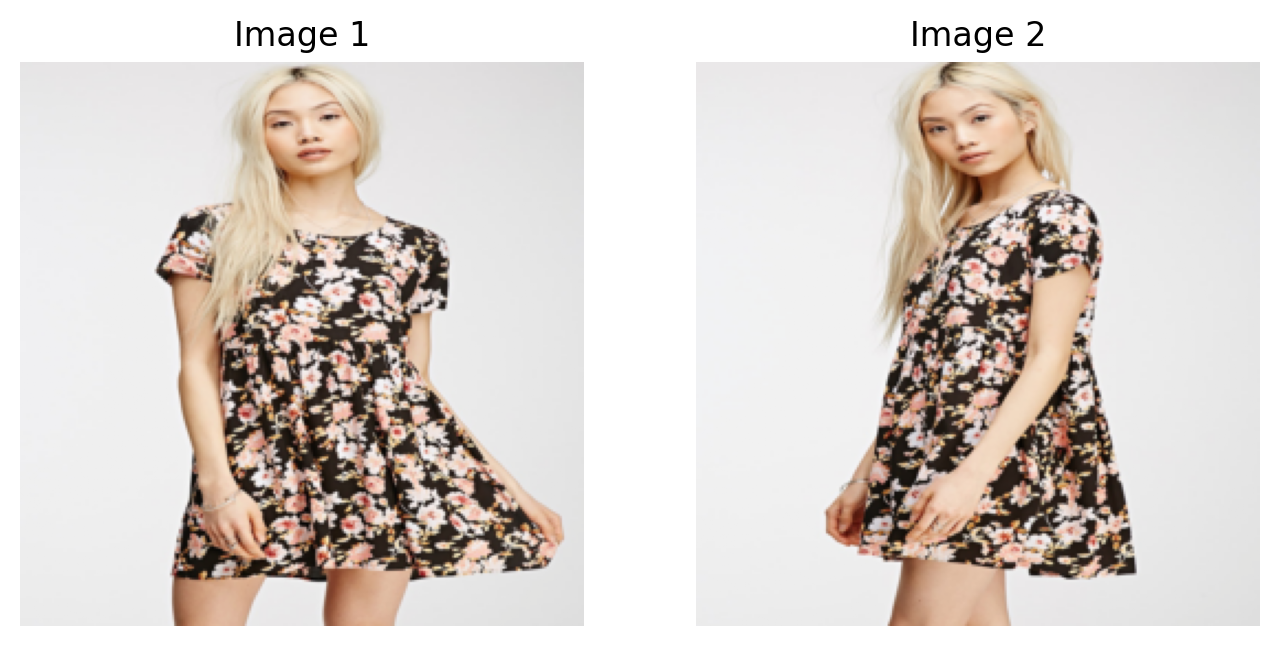


--- Retrieving Pair 1 ---
Pair 1:
 - Target: 1 (Positive)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


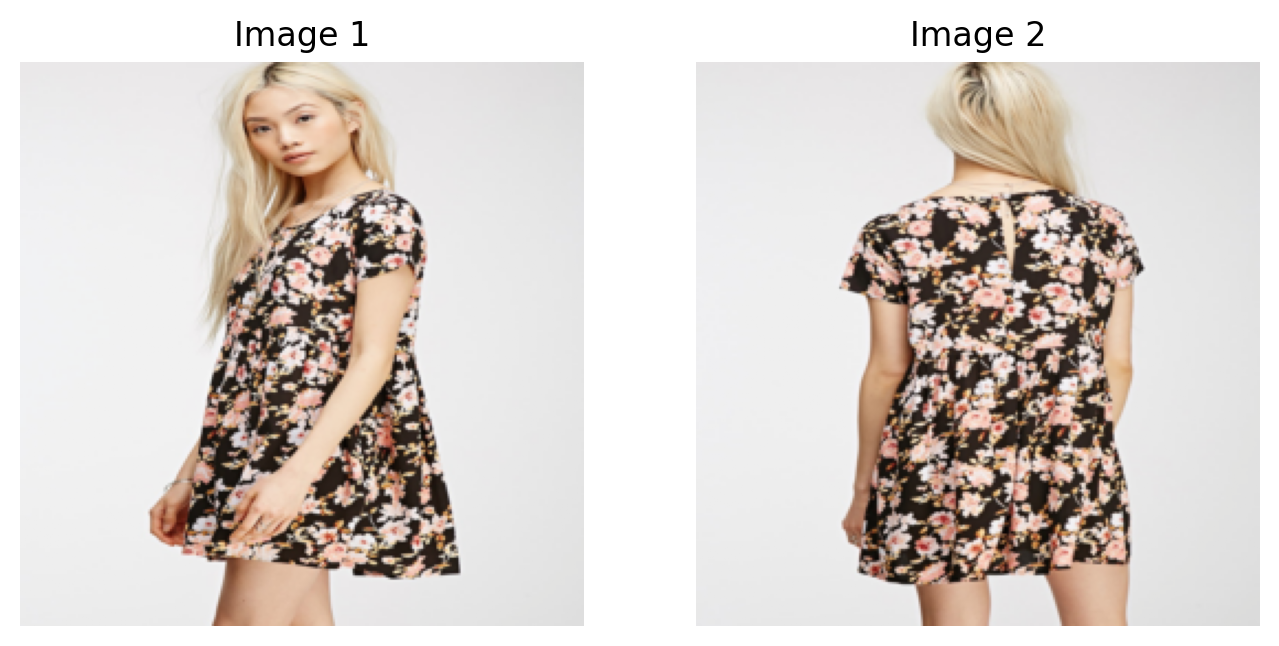


--- Retrieving Pair 2 ---
Pair 2:
 - Target: 0 (Negative)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


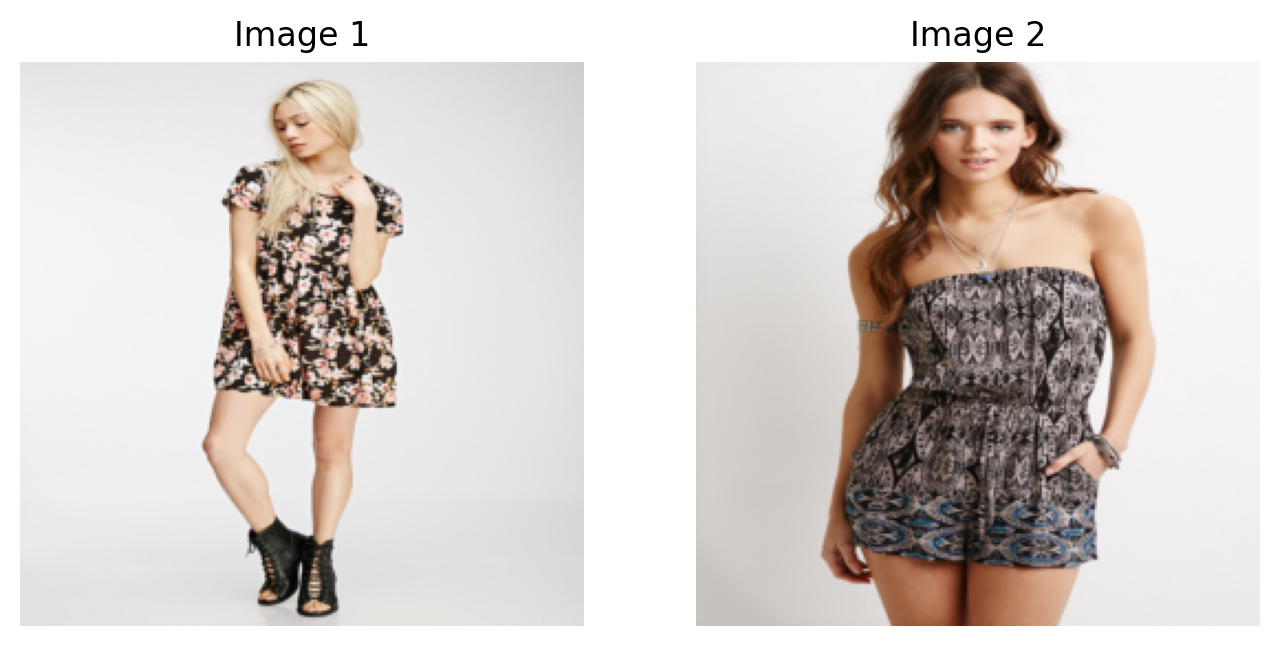


--- Retrieving Pair 3 ---
Pair 3:
 - Target: 1 (Positive)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


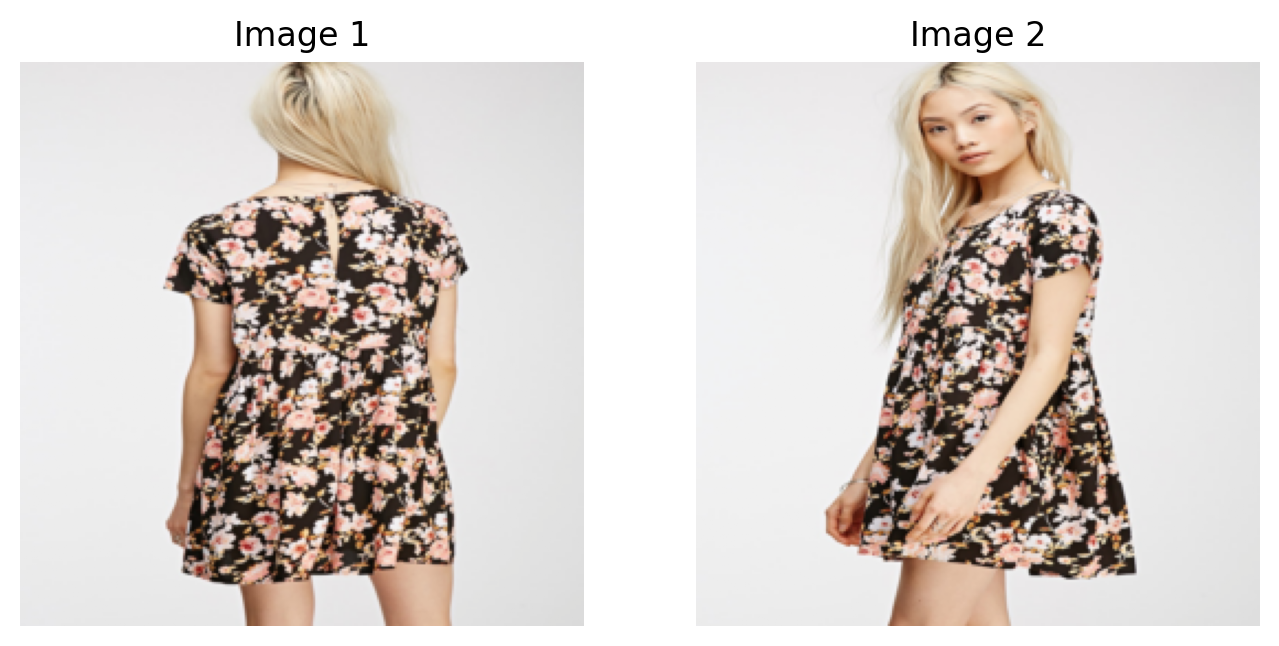


--- Retrieving Pair 4 ---
Pair 4:
 - Target: 1 (Positive)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


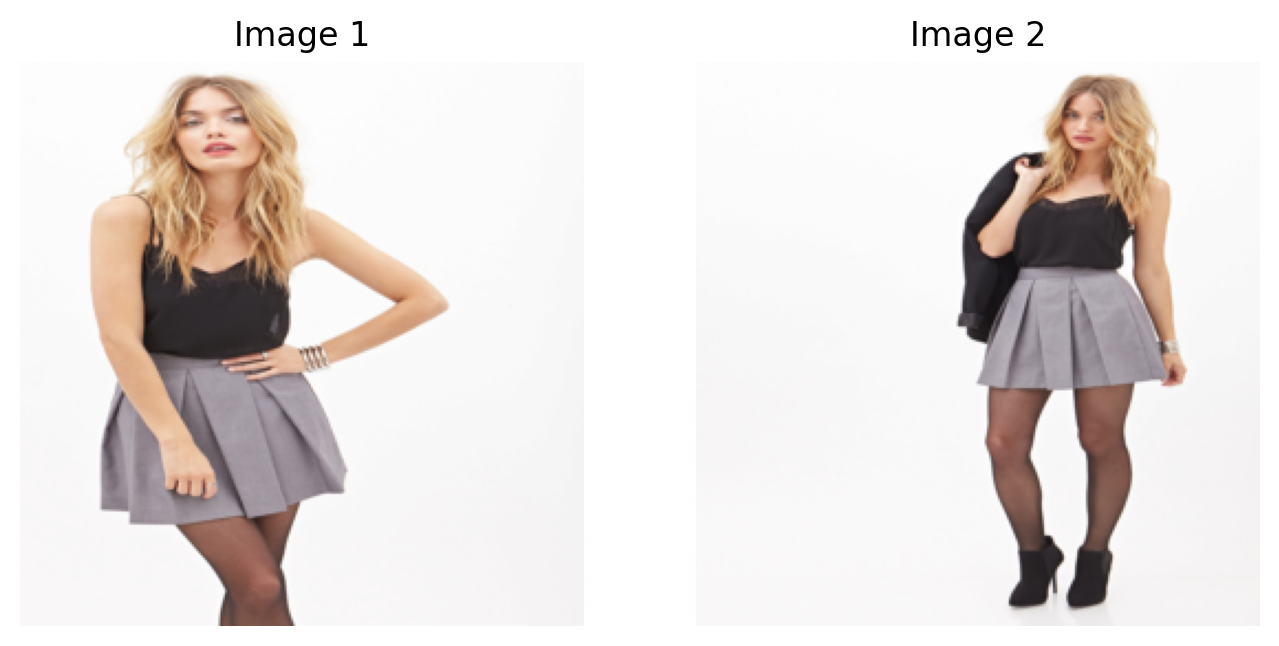


--- Retrieving Pair 5 ---
Pair 5:
 - Target: 1 (Positive)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


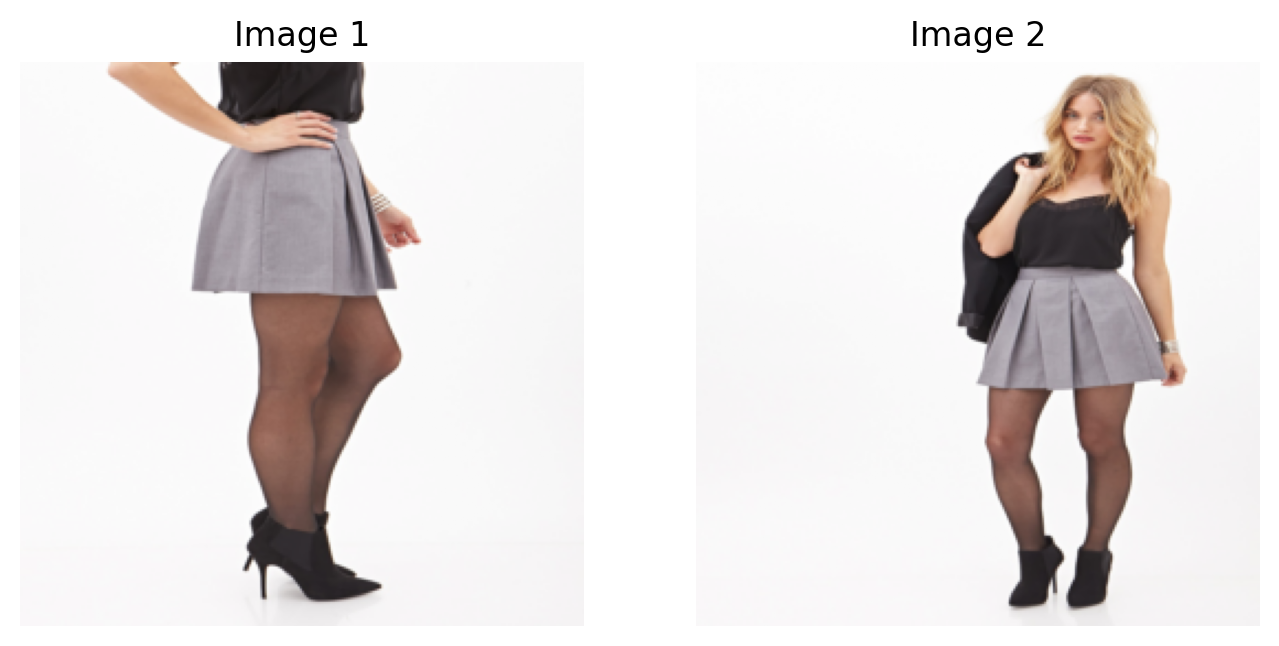


--- Retrieving Pair 6 ---
Pair 6:
 - Target: 0 (Negative)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


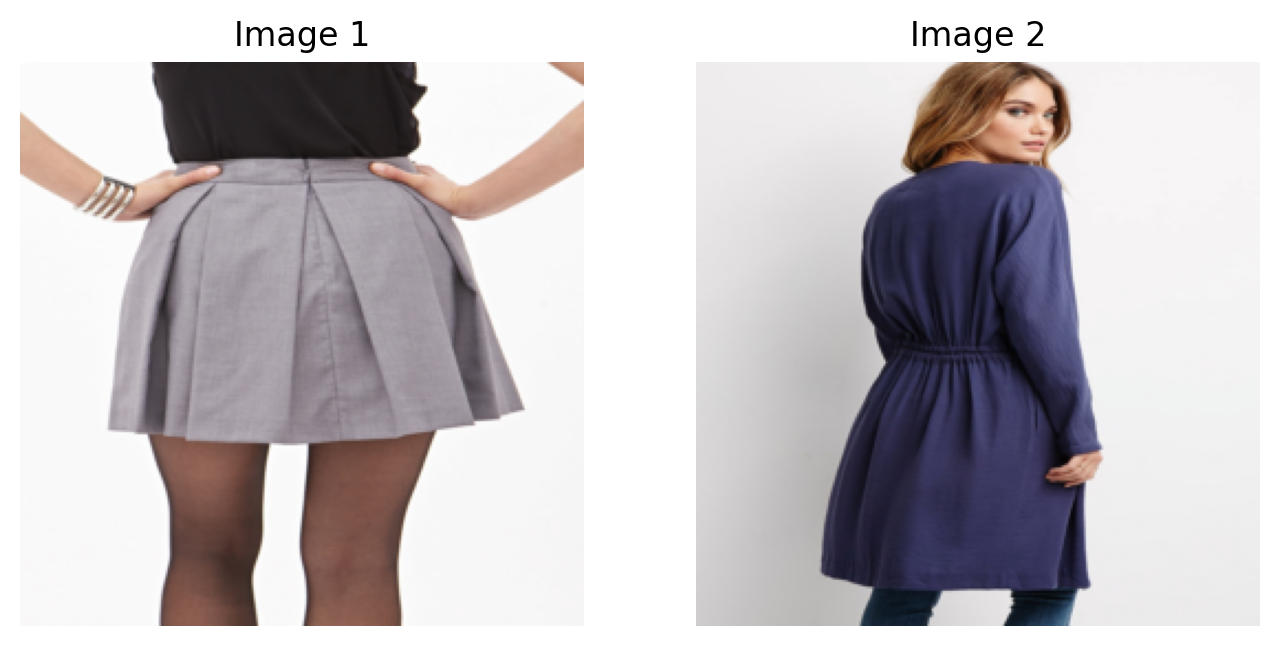


--- Retrieving Pair 7 ---
Pair 7:
 - Target: 0 (Negative)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


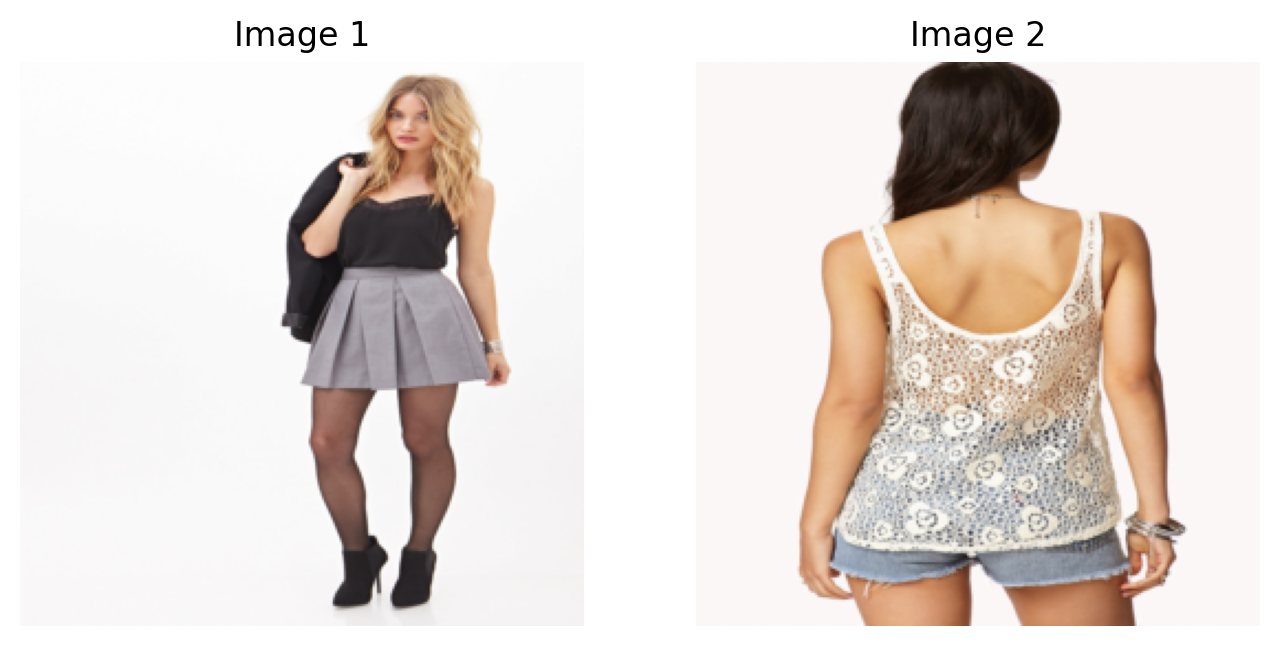


--- Retrieving Pair 8 ---
Pair 8:
 - Target: 0 (Negative)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


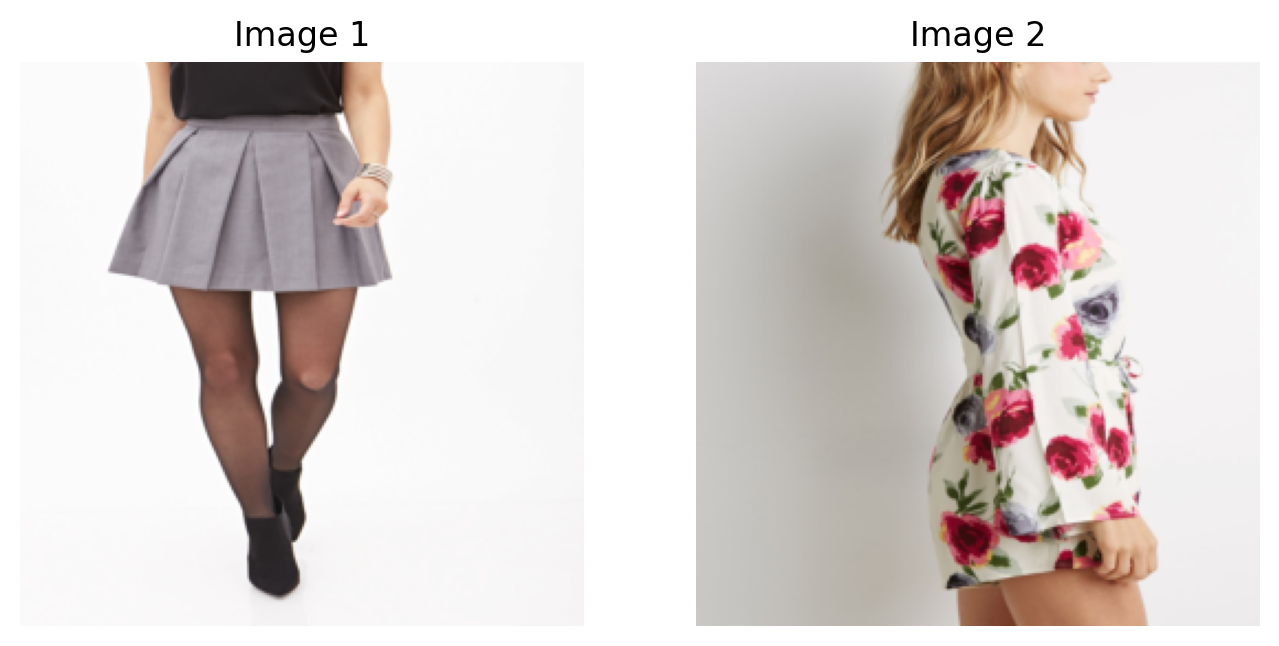


--- Retrieving Pair 9 ---
Pair 9:
 - Target: 0 (Negative)
 - Image 1 : torch.Size([3, 256, 256])
 - Image 2 Shape: torch.Size([3, 256, 256])


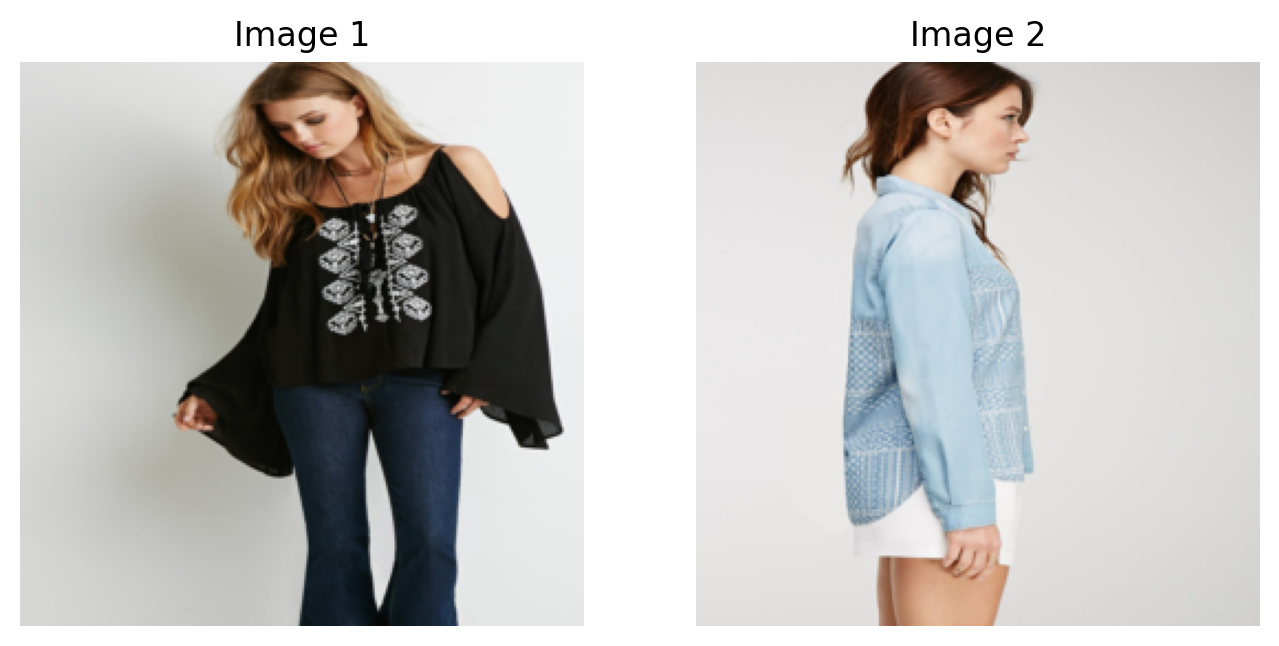

In [6]:
import torch
import matplotlib.pyplot as plt

# Assuming 'siamese_dataset' is your dataset and each item is a tuple (image1, image2), target

# Example: Retrieve and print out details for the first 10 pairs
for idx in range(10):
    print(f"\n--- Retrieving Pair {idx} ---")
    (image1, image2), target = siamese_dataset[idx]

    print(f"Pair {idx}:")
    print(f" - Target: {target} {'(Positive)' if target == 1 else '(Negative)'}")
    print(f" - Image 1 : {image1.shape}")
    print(f" - Image 2 Shape: {image2.shape}")

    # Undo Normalize: Multiply by std and add mean (assuming ImageNet stats)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)  # Mean of ImageNet dataset (C, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)  # Std of ImageNet dataset (C, 1, 1)
    
    image1 = image1 * std + mean  # Undo normalization for image 1
    image2 = image2 * std + mean  # Undo normalization for image 2

    # Optional: Display the images using matplotlib
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(image1.permute(1, 2, 0))  # Permute for visualization (C, H, W) -> (H, W, C)
    axes[0].set_title("Image 1")
    axes[0].axis('off')

    axes[1].imshow(image2.permute(1, 2, 0))
    axes[1].set_title("Image 2")
    axes[1].axis('off')

    plt.show()


In [81]:
print(f"Dataset size: {len(siamese_dataset)}")

Dataset size: 25882


In [21]:
from torch.utils.data import DataLoader
siamese_dataloader = DataLoader(
    siamese_dataset, 
    batch_size=16, 
    shuffle=True, 
    num_workers=16,  # Number of parallel workers for data loading
)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
from torchvision import models

arch = models.resnet50
model_name = f'{arch.__name__}'
print(model_name)  # Kết quả: resnet152


resnet50


In [23]:
import torch
import torch.nn as nn
from torchvision import models

class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(dim=1, keepdim=True)

class SiameseNet(nn.Module):
    def __init__(self, arch, pretrained_path=None):
        """
        Args:
            arch: Backbone architecture (e.g., resnet18)
            pretrained_path: Path to the pretrained weights file
        """
        super(SiameseNet, self).__init__()
        # Load backbone without fully connected layers
        base_model = arch(pretrained=False)  # Do not load default weights
        
        # Remove classification layers
        self.cnn = nn.Sequential(
            *list(base_model.children())[:-2],  # Lấy các layer trừ lớp cuối
            nn.AdaptiveAvgPool2d(1),
            L2Norm(),
            nn.Flatten()
        )
        
        # Load weights from file if pretrained_path is provided
        if pretrained_path:
            print("Loading pretrained weights from:", pretrained_path)
            state_dict = torch.load(pretrained_path, map_location='cpu')
            self.cnn.load_state_dict(state_dict, strict=False)

    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2


In [24]:
class ContrastiveLoss(nn.Module):
    """Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """
    def __init__(self, margin=5.):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, ops, target, size_average=True):
        op1, op2 = ops[0], ops[1]
        dist = F.pairwise_distance(op1, op2)
        pdist = dist*target
        ndist = dist*(1-target)
        loss = 0.5* ((pdist**2) + (F.relu(self.margin-ndist)**2))
        return loss.mean() #if size_average else loss.sum()

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# model = SiameseNet(arch)
# #model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


In [26]:
model = SiameseNet(models.resnet18, '/kaggle/input/resnet50/pytorch/default/1/resnet50-0676ba61.pth')

Loading pretrained weights from: /kaggle/input/resnet50/pytorch/default/1/resnet50-0676ba61.pth


/tmp/ipykernel_23/3085186129.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_path, map_location='cpu')


In [27]:
print(model)

SiameseNet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [28]:
import torch
import torch.nn as nn

def train_siamese(model, dataloader, criterion, optimizer, device, num_epochs=10):
    """
    Function to train a Siamese network.

    Args:
        model (nn.Module): The Siamese network model.
        dataloader (DataLoader): PyTorch DataLoader with image pairs and labels.
        criterion (nn.Module): Contrastive loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        device (torch.device): Device to use (CPU or GPU).
        num_epochs (int): Number of epochs for training.

    Returns:
        List of epoch losses.
    """
    model = model.to(device)  # Move model to the specified device (CPU or GPU)
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Loop over the dataloader
        for batch_idx, (images, labels) in enumerate(dataloader):
            # Ensure that the tensors are moved to the same device as the model
            img1, img2 = images
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)  # Move data to the same device

            optimizer.zero_grad()

            # Forward pass, truyền vào cả hai ảnh
            output1, output2 = model(img1, img2)
        
            # Tính toán loss
            loss = criterion((output1, output2), labels)

            # Backpropagation and optimizer step
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print batch loss every 100 batches (or modify as needed
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}")

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print("Training completed!")
    return epoch_losses


In [29]:
import torch.optim as optim
criterion = ContrastiveLoss(margin=0.5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [30]:
num_epochs = 3
losses = train_siamese(model, siamese_dataloader, criterion, optimizer, device, num_epochs)

Epoch 1/3, Batch 1/1618, Loss: 0.0676
Epoch 1/3, Batch 2/1618, Loss: 0.1511
Epoch 1/3, Batch 3/1618, Loss: 0.1023
Epoch 1/3, Batch 4/1618, Loss: 0.1274
Epoch 1/3, Batch 5/1618, Loss: 0.0717
Epoch 1/3, Batch 6/1618, Loss: 0.0860
Epoch 1/3, Batch 7/1618, Loss: 0.0735
Epoch 1/3, Batch 8/1618, Loss: 0.1092
Epoch 1/3, Batch 9/1618, Loss: 0.1121
Epoch 1/3, Batch 10/1618, Loss: 0.1046
Epoch 1/3, Batch 11/1618, Loss: 0.0995
Epoch 1/3, Batch 12/1618, Loss: 0.0995
Epoch 1/3, Batch 13/1618, Loss: 0.0727
Epoch 1/3, Batch 14/1618, Loss: 0.0977
Epoch 1/3, Batch 15/1618, Loss: 0.0826
Epoch 1/3, Batch 16/1618, Loss: 0.0857
Epoch 1/3, Batch 17/1618, Loss: 0.0751
Epoch 1/3, Batch 18/1618, Loss: 0.0990
Epoch 1/3, Batch 19/1618, Loss: 0.0662
Epoch 1/3, Batch 20/1618, Loss: 0.0630
Epoch 1/3, Batch 21/1618, Loss: 0.0361
Epoch 1/3, Batch 22/1618, Loss: 0.0801
Epoch 1/3, Batch 23/1618, Loss: 0.1151
Epoch 1/3, Batch 24/1618, Loss: 0.1342
Epoch 1/3, Batch 25/1618, Loss: 0.0939
Epoch 1/3, Batch 26/1618, Loss: 0.

In [32]:
torch.save(model.state_dict(), '/kaggle/working/siemeseResnet50.pth')

In [ ]:
data.train_ds[0][0].img1
data.train_ds[0][0].img1.data
siam_learner.to_fp32().model.cnn(data.train_ds[0][0].img1.data.unsqueeze(0).cuda())
model_name = f'{arch.__name__}_i{min_images}_l{n_landmarks}-{SZ}'
learn.save(model_name)
previous_model_name = model_name
previous_model_name